# Muestreo Estratificado de Tweets Políticos Colombianos

## Objetivo

Crear una muestra representativa de tweets que mantenga las proporciones por:
- Usuario (político)
- Fecha (año y mes)

---

## Configuración inicial

In [1]:
# Instalación de librerías
!pip install pandas matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

## Carga de datos

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/Clases/NLP para ciencias sociales/99. Datos/tweets.csv'  # Replace with the actual path
df = pd.read_csv(file_path)
print(df.head())

                        _id    author/name               author/url  \
0  677f1ef0782ccacddc4d9b02  Iván Duque 🇨🇴  https://x.com/IvanDuque   
1  677f1ef0782ccacddc4d9b03  Iván Duque 🇨🇴  https://x.com/IvanDuque   
2  677f1ef0782ccacddc4d9b04  Iván Duque 🇨🇴  https://x.com/IvanDuque   
3  677f1ef0782ccacddc4d9b05  Iván Duque 🇨🇴  https://x.com/IvanDuque   
4  677f1ef0782ccacddc4d9b06  Iván Duque 🇨🇴  https://x.com/IvanDuque   

  author/userName                       createdAt  quoteCount  replyCount  \
0       IvanDuque  Mon May 06 23:57:09 +0000 2019        15.0        79.0   
1       IvanDuque  Mon May 06 23:51:05 +0000 2019         5.0        20.0   
2       IvanDuque  Mon May 06 23:34:55 +0000 2019        20.0        54.0   
3       IvanDuque  Mon May 06 23:23:36 +0000 2019         0.0         7.0   
4       IvanDuque  Mon May 06 23:02:24 +0000 2019         2.0        12.0   

   retweetCount              source  \
0         456.0  Twitter for iPhone   
1         153.0  Twitter for iPh

## Limpieza de datos

In [5]:
def clean_politician_name(name):
    """Normaliza nombres de políticos"""
    if pd.isna(name):
        return name

    # Limpiar caracteres especiales
    clean_name = str(name).replace('🇨🇴', '').strip()

    # Mapeo estándar
    name_mapping = {
        'Iván Duque': 'Iván Duque',
        'Ivan Duque': 'Iván Duque',
        'Gustavo Petro': 'Gustavo Petro',
        'Álvaro Uribe Vélez': 'Álvaro Uribe',
        'Alvaro Uribe Vélez': 'Álvaro Uribe',
        'Gustavo Bolívar': 'Gustavo Bolívar',
        'Gustavo Bolivar': 'Gustavo Bolívar'
    }

    return name_mapping.get(clean_name, clean_name)

In [6]:
# Seleccionar columnas relevantes
columns_to_keep = ['_id', 'author/name', 'createdAt', 'text']
available_columns = [col for col in columns_to_keep if col in df.columns]

df_clean = df[available_columns].copy()

# Renombrar columnas
column_mapping = {
    '_id': 'id',
    'author/name': 'politico',
    'createdAt': 'fecha_raw',
    'text': 'texto'
}

df_clean = df_clean.rename(columns={k: v for k, v in column_mapping.items()
                                  if k in df_clean.columns})

# Limpiar nombres
df_clean['politico'] = df_clean['politico'].apply(clean_politician_name)

# Procesar fechas
df_clean['fecha'] = pd.to_datetime(df_clean['fecha_raw'], errors='coerce')
df_clean['año'] = df_clean['fecha'].dt.year
df_clean['mes'] = df_clean['fecha'].dt.month
df_clean['año_mes'] = df_clean['fecha'].dt.to_period('M')

# Filtros básicos
df_clean = df_clean.dropna(subset=['texto', 'fecha'])
df_clean = df_clean[df_clean['texto'].str.len() >= 20]
df_clean = df_clean[(df_clean['año'] >= 2019) & (df_clean['año'] <= 2024)]

print(f"Dataset después de limpieza: {len(df_clean):,} tweets")
print(f"Políticos: {df_clean['politico'].nunique()}")
print(f"Período: {df_clean['año'].min()} - {df_clean['año'].max()}")

Dataset después de limpieza: 57,362 tweets
Políticos: 4
Período: 2019.0 - 2024.0


## Análisis exploratorio

In [7]:
# Distribución por político
print("Distribución por político:")
politician_dist = df_clean['politico'].value_counts()
for politician, count in politician_dist.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {politician}: {count:,} tweets ({percentage:.1f}%)")

# Distribución por año
print("\nDistribución por año:")
year_dist = df_clean['año'].value_counts().sort_index()
for year, count in year_dist.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {year}: {count:,} tweets ({percentage:.1f}%)")

# Tabla cruzada
print("\nTabla cruzada (Año x Político):")
cross_table = df_clean.groupby(['año', 'politico']).size().unstack(fill_value=0)
print(cross_table)

Distribución por político:
  Gustavo Petro: 19,403 tweets (33.8%)
  Álvaro Uribe: 13,305 tweets (23.2%)
  Gustavo Bolívar: 13,121 tweets (22.9%)
  Iván Duque: 11,533 tweets (20.1%)

Distribución por año:
  2019.0: 14,225 tweets (24.8%)
  2020.0: 13,756 tweets (24.0%)
  2021.0: 11,094 tweets (19.3%)
  2022.0: 8,755 tweets (15.3%)
  2023.0: 5,758 tweets (10.0%)
  2024.0: 3,774 tweets (6.6%)

Tabla cruzada (Año x Político):
politico  Gustavo Bolívar  Gustavo Petro  Iván Duque  Álvaro Uribe
año                                                               
2019.0               2229           4746        2959          4291
2020.0               2937           5586        2222          3011
2021.0               2771           2486        3107          2730
2022.0               2712           2247        2526          1270
2023.0               1720           2297         386          1355
2024.0                752           2041         333           648


## Visualización de distribuciones originales


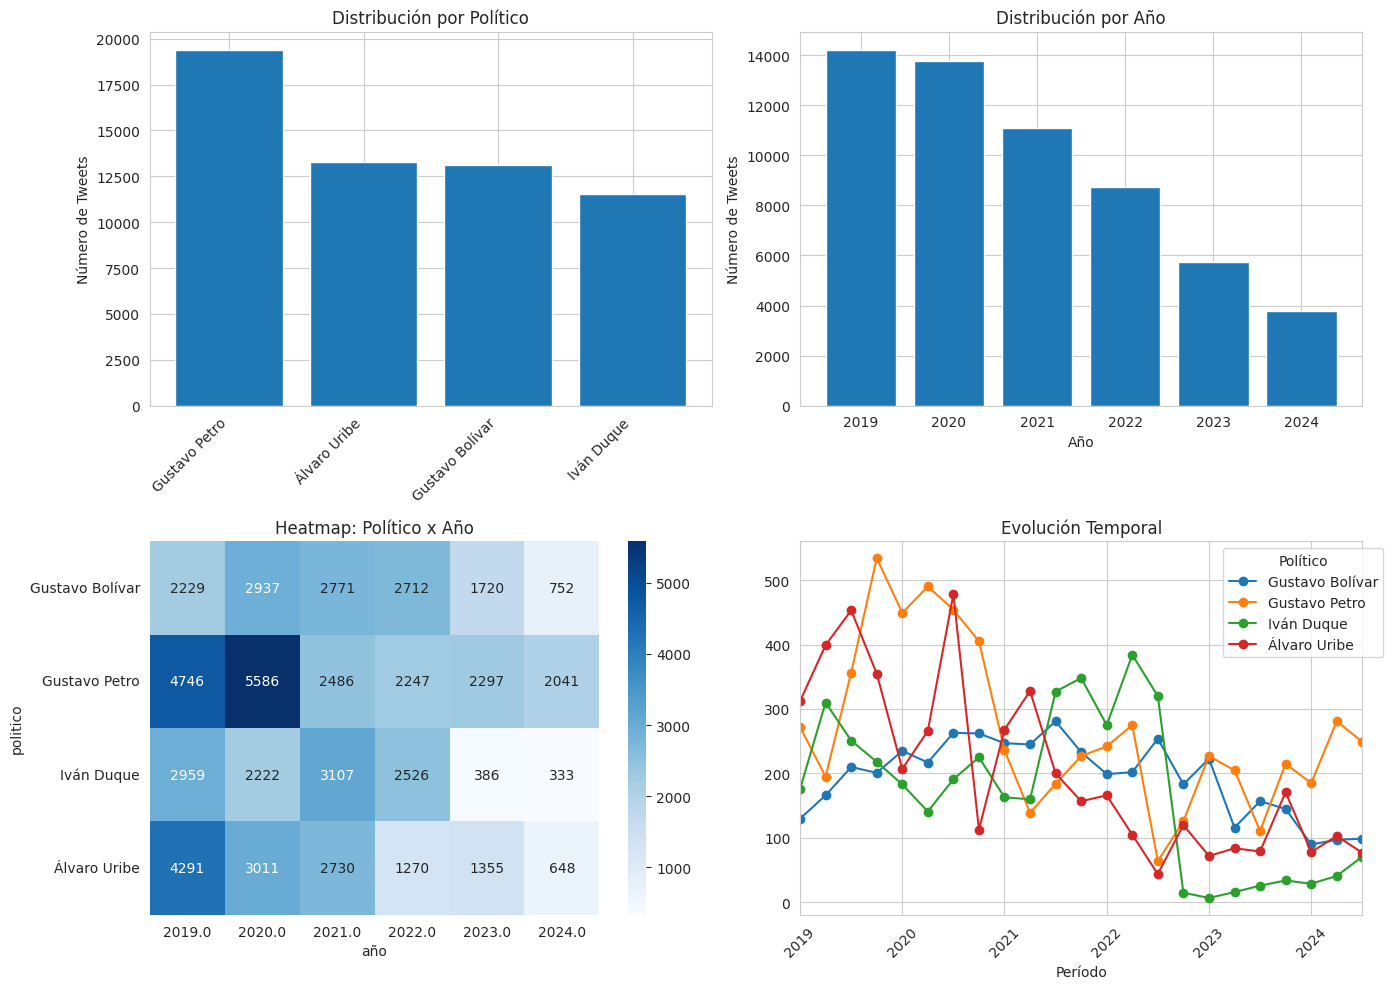

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribución por político
politician_counts = df_clean['politico'].value_counts()
axes[0,0].bar(range(len(politician_counts)), politician_counts.values)
axes[0,0].set_xticks(range(len(politician_counts)))
axes[0,0].set_xticklabels(politician_counts.index, rotation=45, ha='right')
axes[0,0].set_title('Distribución por Político')
axes[0,0].set_ylabel('Número de Tweets')

# Distribución por año
year_counts = df_clean['año'].value_counts().sort_index()
axes[0,1].bar(year_counts.index, year_counts.values)
axes[0,1].set_title('Distribución por Año')
axes[0,1].set_xlabel('Año')
axes[0,1].set_ylabel('Número de Tweets')

# Heatmap
pivot_table = df_clean.groupby(['año', 'politico']).size().unstack(fill_value=0)
sns.heatmap(pivot_table.T, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('Heatmap: Político x Año')

# Evolución temporal
monthly_data = df_clean.groupby(['año_mes', 'politico']).size().unstack(fill_value=0)
monthly_sample = monthly_data.iloc[::3]  # Cada 3 meses para legibilidad
monthly_sample.plot(kind='line', ax=axes[1,1], marker='o')
axes[1,1].set_title('Evolución Temporal')
axes[1,1].set_xlabel('Período')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(title='Político', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

## Función de muestreo estratificado

In [10]:
def stratified_sampling(df, sample_size=4000, method='proportional', random_state=42):
    """
    Realiza muestreo estratificado por político y fecha

    Parameters:
    - df: DataFrame con los tweets
    - sample_size: Tamaño de muestra deseado
    - method: 'proportional' o 'balanced'
    - random_state: Semilla para reproducibilidad
    """
    np.random.seed(random_state)

    # Crear estratos combinando político y año-mes
    df['stratum'] = df['politico'] + '_' + df['año_mes'].astype(str)

    stratum_counts = df['stratum'].value_counts()
    print(f"Estratos identificados: {len(stratum_counts)}")
    print(f"Rango por estrato: {stratum_counts.min()} - {stratum_counts.max()}")

    if method == 'proportional':
        # Mantener proporciones originales
        stratum_proportions = df['stratum'].value_counts(normalize=True)
        sample_per_stratum = (stratum_proportions * sample_size).round().astype(int)
    else:
        # Distribuir equitativamente
        tweets_per_stratum = sample_size // len(stratum_counts)
        sample_per_stratum = pd.Series(tweets_per_stratum, index=stratum_counts.index)

    # Ajustar por disponibilidad
    adjusted_sample = {}
    for stratum, target_n in sample_per_stratum.items():
        available_n = len(df[df['stratum'] == stratum])
        adjusted_sample[stratum] = min(int(target_n), available_n)

    # Realizar muestreo
    samples = []
    summary_data = []

    for stratum, n in adjusted_sample.items():
        if n > 0:
            stratum_data = df[df['stratum'] == stratum]
            stratum_sample = stratum_data.sample(n=n, random_state=random_state)
            samples.append(stratum_sample)

            politician, year_month = stratum.split('_', 1)
            summary_data.append({
                'politico': politician,
                'año_mes': year_month,
                'disponible': len(stratum_data),
                'muestreado': n,
                'proporcion': n / len(stratum_data)
            })

    final_sample = pd.concat(samples, ignore_index=True)
    summary_df = pd.DataFrame(summary_data)

    print(f"Muestra obtenida: {len(final_sample):,} tweets")
    print(f"Estratos muestreados: {len(samples)}")

    return final_sample.drop('stratum', axis=1), summary_df

## Ejecutar muestreo estratificado

In [11]:
# Realizar muestreo
sample_df, sampling_summary = stratified_sampling(
    df_clean,
    sample_size=4000,
    method='proportional',
    random_state=42
)

print("Muestreo completado")
print(f"Tweets en muestra: {len(sample_df):,}")
print(f"Políticos en muestra: {sample_df['politico'].nunique()}")

Estratos identificados: 270
Rango por estrato: 5 - 879
Muestra obtenida: 4,005 tweets
Estratos muestreados: 268
Muestreo completado
Tweets en muestra: 4,005
Políticos en muestra: 4


## Guardar resultados

In [14]:
# Guardar archivos
sample_df.to_csv('tweets_muestra_estratificada.csv', index=False)
#sampling_summary.to_csv('resumen_muestreo.csv', index=False)

print("Archivos guardados:")
print("- tweets_muestra_estratificada.csv")
print("- resumen_muestreo.csv")

# Descargar archivos
from google.colab import files
files.download('tweets_muestra_estratificada.csv')
#files.download('resumen_muestreo.csv')

print("Archivos descargados exitosamente")

Archivos guardados:
- tweets_muestra_estratificada.csv
- resumen_muestreo.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivos descargados exitosamente
